<h1> Generate F.C. limit </h1>

In [1]:
from __future__ import division
import sys
home_dir=!echo "$HOME"
sys.path.insert(2,home_dir[0]+'/iPyNb/NERSC_Import') 
from pyROOT_import import *
from pyNEST import *
from ROOT import TH2D
import time
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0) # set size of figures"
plt.rcParams.update({'font.size': 20})
#plt.rc('text', usetex=True)

Populating the interactive namespace from numpy and matplotlib


TROOT::Append:0: RuntimeWarning: Replacing existing TH1: LCE (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: EField (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: LCE (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: EField (Potential memory leak).
`%matplotlib` prevents importing * from pylab and numpy


<h1> WS cuts </h1>

In [2]:
#WS cuts
S1_min=0
S1_max=20
S2raw_min=450
#NS1_coin_req=3

#define. calc LZ  nominal exposure
def calc_exposure(S1_cut, S2_cut, S1_win_max=20):
    LZ_count=sum(S1_cut<S1_win_max)/Det_exposure_factor
    LZ_count_underNr=sum((S1_cut<S1_win_max) & (log10(S2_cut/S1_cut)<sNR(S1_cut)))/Det_exposure_factor
    sig_LZ_count=sqrt(sum(S1_cut<S1_win_max))/Det_exposure_factor
    sig_LZ_count_underNr=sqrt(sum((S1_cut<20) & (log10(S2_cut/S1_cut)<sNR(S1_cut))))/Det_exposure_factor
    print('Count (0 to '+str(S1_win_max) + ' S1) = '+'{:.3f}'.format(LZ_count) + ' +/- ' + '{:.3f}'.format(sig_LZ_count) )
    print('Count below NR mean (0 to '+str(S1_win_max) + ' S1) = '+'{:.3f}'.format(LZ_count_underNr) + ' +/- ' + '{:.3f}'.format(sig_LZ_count_underNr) )

<h1> Generate ER and NR bands </h1>

In [7]:
##############################################################################
#Generate Flat ER and 50 GeV WIMP NR spectra:
##############################################################################
#LZ
NEST =NEST_setup(Det='LZ', nFold=3, g1=0.075, custom=True)
S1_bin_cen_n, mean_S2oS1_n, std_S2oS1_n, S1_bin_cen_e, mean_S2oS1_e, std_S2oS1_e, E_bin_cen_e,\
Eff_e, E_bin_cen_n, Eff_n,num_leak_e, num_total_e, leak_gauss_e, sNR = \
genBands(NEST=NEST,S2raw_min=450,nSim=1e6,mWmp=50)

#get NR mean, with a smooth spline
#sNR = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n,s=.005)

#calculate NR ER discrimination
leak_cut=(S1_bin_cen_e>1) & (S1_bin_cen_e<20)
discrim=100*(1-sum(num_leak_e[leak_cut])/sum(num_total_e[leak_cut]))
discrim

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: LCE (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: EField (Potential memory leak).


99.720137812614979

<h1> LZ lim generation </h1>

In [9]:
def LZ_nom_lim(make_plot=True, mWimp = np.logspace(np.log10(6),np.log10(2000),30), f_drift=-1, Det='LZ',custom=True,\
               nom_ER_BG=6.3, nom_NR_BG=0.5, nom_B8=0, mWB8=15, g1=0.075, eff_extract=0.95, \
               e_lifetime=850, nSim=1e5, mass_Fid=5600, livetime=1000, \
               S1_min=0, S2raw_min=450, E_min=0, S1_max=20, ER_max=100, nFold=3, name='LZ_FC_nom'):
    """
    #Generate the nominal LZ limit
    #Inputs ...
    # Array of WIMP masses, in units of GeV/c^2, logarithmically spaced
    # Drift field V/cm
    # nominal ER background = 1.5 events
    # nominal NR background = 0.4 events
    # g1
    # Extraction Eff
    # electron lifetime in micro seconds
    # drift distance at the center of the detector
    # number of events to simulate (50,000)
    # Fiducial mass in kg
    # livetime in days
    # Single photon resolution in PE
    # Single electron size in PE = 50
    # Single electron res in PE = 9.9
    # S2_min = 250 PHE ~ 5 electrons extracted
    # S1_min (S1 PE cut off) ~ 3 PE
    # num of electrons min (minimum number of electrons extracted)
    # E_min, the NR energy cut off, default to 3 KeVnr
    # Max S1 in search window, and when calculating acceptance from a flat NR BG
    # MAX E when simulating a flat NR spectrum to get acceptance
    """
    
    start_time = time.time()
    
    #E field [V/cm] and discrimination vs. g1 (0.04, 0.07, 0.10) ... from Matthew
    aa=np.array([50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000])
    bb=np.array([0.0080, 0.0109, 0.0108, 0.0098, 0.0086, 0.0082, 0.0076, 0.0067, 0.0060, 0.0063, 0.0063, 0.0064])
    cc=np.array([0.0068, 0.0089, 0.0088, 0.0078, 0.0068, 0.0063, 0.0059, 0.0053, 0.0049, 0.0050, 0.0050, 0.0055])
    dd=np.array([0.0055, 0.0070, 0.0067, 0.0057, 0.0050, 0.0044, 0.0042, 0.0040, 0.0038, 0.0037, 0.0037, 0.0047])

    #Critical numbers for 5 and 3 sigma discovery with a fixed BG = 0.2
    #crit_BGs=np.array([0, 0.5, 1.0, 1.5, 1.9, 2.5, 5, 10, 20, 50])
    #crit_sig5=np.array([6, 9, 10, 12, 13, 15, 20, 30, 47, 90])
    #crit_sig3=np.array([3, 5, 6, 7, 8, 9, 14, 21, 35, 73])

    #With a sigma BG = 0.1 * BG
    crit_BGs=np.array([0, 0.25, 0.5, 1, 2, 5, 10, 20, 50])
    crit_sig3=np.array([1, 3, 4, 6, 8, 14, 22, 37, 79])
    crit_sig5=np.array([2, 6, 8, 10, 13, 21, 32, 50, 100])
        
    #With a sigma BG = 0.5 * BG
    #crit_BGs=np.array([0, 0.25, 0.5, 1, 2, 5, 10, 20, 50])
    #crit_sig3=np.array([1, 4,  5, 7, 10, 18, 32, 57, 133])
    #crit_sig5=np.array([2, 7, 9, 12, 17, 30, 49, 85, 192])

    sigAcc = np.empty_like(mWimp)
    accept = np.empty_like(mWimp)
    sigma_UL = np.empty_like(mWimp)
    Disc_Pot_sig3 = np.empty_like(mWimp) #Discovery Potential
    Disc_Pot_sig5 = np.empty_like(mWimp)
    #SE_res=np.sqrt(SE_size)/SE_size # single electron resolution of the PMT
    #ER_leak_corr_g1... interpolate leakage fraction table and normalize to leakage at 700V/cm and g1=0.07. Original BG calc
    #ER_leak_corr_g1=np.interp( g1, np.array([0.04, 0.07, 0.10]),np.array([np.interp(f_drift,aa,bb), np.interp(f_drift,aa,cc), np.interp(f_drift,aa,dd)]) )/cc[7]
    numBG_predict_list= [nom_NR_BG + nom_ER_BG] # NR + ER background
    nSig_90UL_sense_list = [np.sqrt(2.463*numBG_predict_list[0]+1.101) + 1.416]
    
    NEST =NEST_setup(Det=Det, f_drift=f_drift, nFold=nFold, g1=g1, eff_extract=eff_extract, \
                     e_lifetime=e_lifetime, custom=custom)
    S1_bin_cen_n, mean_S2oS1_n, std_S2oS1_n, S1_bin_cen_e, mean_S2oS1_e, std_S2oS1_e, E_bin_cen_e,\
    Eff_e, E_bin_cen_n, Eff_n,num_leak_e, num_total_e, leak_gauss_e, sNR = \
    genBands(NEST=NEST,S2raw_min=S2raw_min,nSim=1e6,mWmp=50)
    
    print("k = 0 of {:d}	Mass[GeV/c^2]	90%CL [cm^2]	3 sigma	 5 sigma".format(len(mWimp)))
    NEST.SetParticleType(0) #set NEST to NR for WIMPs
    #loop through WIMP masses
    for k, mWmp in enumerate(mWimp):
        #switch background prediction depending on mWmp at mass given by mWB8
        numBG_predict=numBG_predict_list[0]
        nSig_90UL_sense=nSig_90UL_sense_list[0]
        
        Nph, Ne, S1, S2, S1c, S2c, WmpRate, Det_exposure_factor=WIMP2NphNe(NEST=NEST,mWmp=mWmp,nSim=nSim,showFig=False)
        WS_cut=(S1c>0) & (S2>=S2raw_min)
        S1_cut=S1c[WS_cut]
        S2_cut=S2c[WS_cut]
        s1_range=inrange(S1_cut,[0.1,S1_max])
        cutSig = WS_cut
        accept[k]=sum(log10(S2_cut[s1_range]/S1_cut[s1_range]) < np.interp(S1_cut[s1_range],S1_bin_cen_n,mean_S2oS1_n))/len(S1_cut[s1_range])
        #sigAcc[k] = eff(cutSig)*(accept[k] ) #eff doesn't work in 2.7
        sigAcc[k] = (sum(cutSig) / len(cutSig)) * (accept[k]) #for some reason eff doesn't work with python2.7 ?
        nSig_obs_1e36 = WmpRate * sigAcc[k] * mass_Fid * livetime #WIMP rate is evts/kg/day/pb
        sigma_UL[k] = nSig_90UL_sense * (1e-36) / nSig_obs_1e36
        
        #Find Discovery Potential, 50% of the time at 3 and 5 sigma.
        ncrit_sig3=np.ceil(np.interp(numBG_predict,crit_BGs,crit_sig3))
        ncrit_sig5=np.ceil(np.interp(numBG_predict,crit_BGs,crit_sig5))
        S_crit=nSig_obs_1e36 / (1e-36) #scaling factor. N_events/Cross_Section
        Disc_Pot_sig3[k]=(ncrit_sig3-numBG_predict) / S_crit
        Disc_Pot_sig5[k]=(ncrit_sig5-numBG_predict) / S_crit
        
        print("k = {:d} of {:d}	{:.2f}	{:.2e}	{:.2e}	{:.2e}".format(k+1,len(mWimp),mWmp, sigma_UL[k], Disc_Pot_sig3[k], Disc_Pot_sig5[k]))

    if make_plot:
        #Make plot
        mpl.pyplot.figure();
        mpl.pyplot.clf()
        mpl.pyplot.hold('on')
        mpl.pyplot.loglog(mWimp,Disc_Pot_sig5 ,'-', linewidth=3,color='m')
        mpl.pyplot.loglog(mWimp,Disc_Pot_sig3 ,'--', linewidth=3,color='m')
        mpl.pyplot.loglog(mWimp, sigma_UL,'-', linewidth=3,color='b')
        #plot(mWimp, sigma_UL,'-', linewidth=3)
        #gca().set_xscale('log')
        #set(gca,'xscale','log')
        #gca().set_yscale('log')
        mpl.pyplot.grid('on')
        mpl.pyplot.minorticks_on()
        mpl.pyplot.xlabel('WIMP Mass [GeV/$c^2$]')
        mpl.pyplot.ylabel('WIMP-nucleon cross section [cm$^2$]')
        mpl.pyplot.xlim([6, 2e3])
        mpl.pyplot.legend(('5$\sigma$ median significance','3$\sigma$ median significance','90$\%$ CL'))
        mpl.pyplot.ylim([1e-46, 1e-43])
        mpl.pyplot.grid(which='minor')
        mpl.pyplot.savefig('figs/'+name+'.png',dpi=150)
    
    np.savetxt('data/'+name+'_90CL_lim.txt', np.transpose([mWimp, sigma_UL]), delimiter='\t')
    np.savetxt('data/'+name+'_disc_sig3.txt', np.transpose([mWimp, Disc_Pot_sig3]), delimiter='\t')
    np.savetxt('data/'+name+'_disc_sig5.txt', np.transpose([mWimp, Disc_Pot_sig5]), delimiter='\t')
    
    print ("Time elapsed (seconds) = {:f}".format( time.time() - start_time ))
    
    return True

<h1> Run the code for LZ limit generation </h1>

k = 0 of 30	Mass[GeV/c^2]	90%CL [cm^2]	3 sigma	 5 sigma
total rate above 0.00 keV = 554432 [evts/kg/day per pb]
Detector exposure factor per pb = 3.2208e-08
k = 1 of 30	6.00	2.63e-45	4.76e-45	8.50e-45
total rate above 0.00 keV = 624785 [evts/kg/day per pb]
Detector exposure factor per pb = 2.85813e-08
k = 2 of 30	7.33	4.87e-46	8.81e-46	1.57e-45
total rate above 0.00 keV = 703579 [evts/kg/day per pb]
Detector exposure factor per pb = 2.53804e-08
k = 3 of 30	8.96	1.26e-46	2.27e-46	4.05e-46
total rate above 0.00 keV = 788805 [evts/kg/day per pb]
Detector exposure factor per pb = 2.26382e-08
k = 4 of 30	10.94	4.31e-47	7.80e-47	1.39e-46
total rate above 0.00 keV = 876757 [evts/kg/day per pb]
Detector exposure factor per pb = 2.03673e-08
k = 5 of 30	13.37	1.78e-47	3.21e-47	5.73e-47
total rate above 0.00 keV = 961657 [evts/kg/day per pb]
Detector exposure factor per pb = 1.85691e-08
k = 6 of 30	16.34	9.98e-48	1.81e-47	3.22e-47
total rate above 0.00 keV = 1.0356e+06 [evts/kg/day per pb]
Detect

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: LCE (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: EField (Potential memory leak).


True

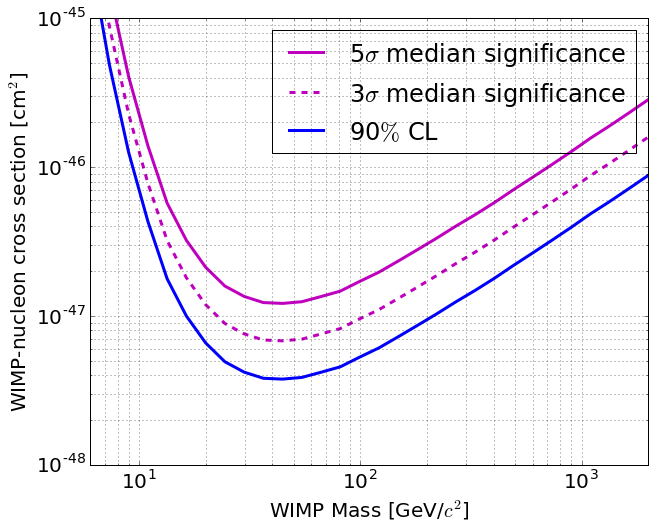

In [5]:
LZ_nom_lim(name='LZ_nom',nom_ER_BG=6.3,S1_max=20)

<h1> Run LUX Limit </h1>

k = 0 of 30	Mass[GeV/c^2]	90%CL [cm^2]	3 sigma	 5 sigma
total rate above 0.00 keV = 554427 [evts/kg/day per pb]
Detector exposure factor per pb = 3.22083e-08
k = 1 of 30	6.00	4.07e-43	6.61e-43	1.26e-42
total rate above 0.00 keV = 624784 [evts/kg/day per pb]
Detector exposure factor per pb = 2.85813e-08
k = 2 of 30	7.33	1.10e-43	1.78e-43	3.40e-43
total rate above 0.00 keV = 703580 [evts/kg/day per pb]
Detector exposure factor per pb = 2.53804e-08
k = 3 of 30	8.96	3.02e-44	4.91e-44	9.37e-44
total rate above 0.00 keV = 788791 [evts/kg/day per pb]
Detector exposure factor per pb = 2.26386e-08
k = 4 of 30	10.94	1.08e-44	1.75e-44	3.35e-44
total rate above 0.00 keV = 876760 [evts/kg/day per pb]
Detector exposure factor per pb = 2.03672e-08
k = 5 of 30	13.37	4.83e-45	7.85e-45	1.50e-44
total rate above 0.00 keV = 961653 [evts/kg/day per pb]
Detector exposure factor per pb = 1.85692e-08
k = 6 of 30	16.34	2.67e-45	4.34e-45	8.28e-45
total rate above 0.00 keV = 1.03562e+06 [evts/kg/day per pb]
Dete

TROOT::Append:0: RuntimeWarning: Replacing existing TH1: LCE (Potential memory leak).
TROOT::Append:0: RuntimeWarning: Replacing existing TH1: EField (Potential memory leak).


True

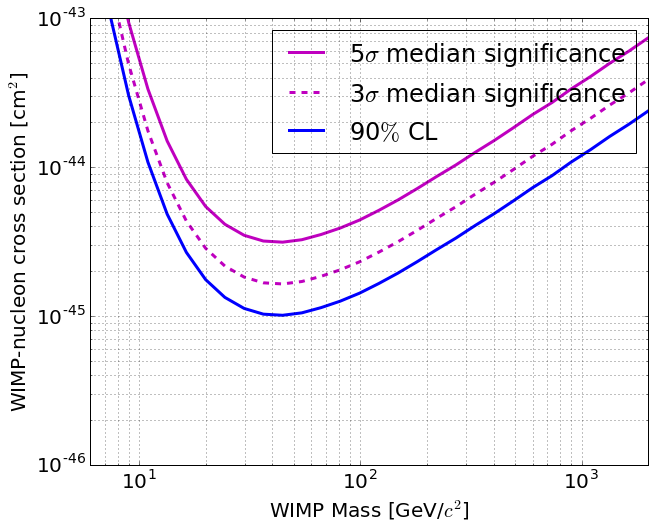

In [10]:
LZ_nom_lim(name='LUX',nom_ER_BG=1.9,S1_max=50,custom=False,mass_Fid=150, livetime=100,S2raw_min=150)

<h1> Check NR interpolation </h1>

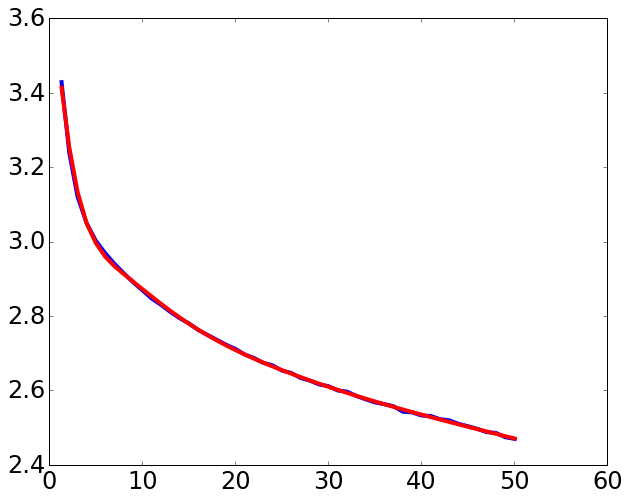

In [74]:
plot(S1_bin_cen_n,mean_S2oS1_n,'-b',linewidth=4)
#get NR mean, with a smooth spline
sNR = ip.UnivariateSpline(S1_bin_cen_n, mean_S2oS1_n,s=.001)
plot(S1_bin_cen_n,sNR(S1_bin_cen_n),'-r',linewidth=4)